In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import zipfile 
import os
import matplotlib.pyplot as plt

# Transfer Learning scaling up

1. Downloading and preparing 10% of the Food101 data
2. Training a feature extraction transfer Learning Model on 10% of the Food101 training data
3.Fine tuning our feature extraction model
4. Saving and loaded out trained model
5. Evaluating the performance of our food vision model trained on 10% of the pretrained data 
  . Finding our model's most wrong predictions
6. Making predictions with our Food Vision Model on custom images of food

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-02 08:10:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 173.194.216.207, 142.250.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   182MB/s    in 9.2s    

2025-01-02 08:10:36 (169 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
ls "/kaggle/working"

101_food_classes_10_percent.zip


In [8]:
import zipfile

zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip")

zip_ref.extractall()
zip_ref.close()

In [9]:
for dirname , _ , images in os.walk("101_food_classes_10_percent"):
  print(f"dirname: {dirname} , folders: {len(_)} , images:{len(images)} ")

dirname: 101_food_classes_10_percent , folders: 2 , images:0 
dirname: 101_food_classes_10_percent/train , folders: 101 , images:0 
dirname: 101_food_classes_10_percent/train/lobster_bisque , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/chocolate_mousse , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/gyoza , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/hummus , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/filet_mignon , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/tiramisu , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/pad_thai , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/churros , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/miso_soup , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/club_sandwich , folders: 0 , images:75 
dirname: 101_food_classes_10_percent/train/gnocchi , folders: 0 , imag

so 101 classes in both training and testing directories 
1. In training directory , each class has 10% that is 75 images
2. In testing directory , each class has all 250 images .

In [10]:
train_dir= "101_food_classes_10_percent/train"
test_dir="101_food_classes_10_percent/test"

In [11]:
ls "101_food_classes_10_percent/train"

apple_pie/           eggs_benedict/            onion_rings/
baby_back_ribs/      escargots/                oysters/
baklava/             falafel/                  pad_thai/
beef_carpaccio/      filet_mignon/             paella/
beef_tartare/        fish_and_chips/           pancakes/
beet_salad/          foie_gras/                panna_cotta/
beignets/            french_fries/             peking_duck/
bibimbap/            french_onion_soup/        pho/
bread_pudding/       french_toast/             pizza/
breakfast_burrito/   fried_calamari/           pork_chop/
bruschetta/          fried_rice/               poutine/
caesar_salad/        frozen_yogurt/            prime_rib/
cannoli/             garlic_bread/             pulled_pork_sandwich/
caprese_salad/       gnocchi/                  ramen/
carrot_cake/         greek_salad/              ravioli/
ceviche/             grilled_cheese_sandwich/  red_velvet_cake/
cheesecake/          grilled_salmon/           risotto/
cheese_plate/     

In [12]:
IMG_SIZE=(224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              batch_size=32,
                                                                              image_size=IMG_SIZE)
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                              label_mode="categorical",
                                                                              batch_size=32,
                                                                              image_size=IMG_SIZE,
                                                                              shuffle=False
                                                                )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [13]:
101*75 ,101*250

(7575, 25250)

 Train a big model with transfer Learning on 10% of 101 food classes

In [14]:
checkpoint_path="101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)




Creating data augmentation layer to put it straigth into my model

In [15]:

data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

setting up base model

In [16]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [18]:
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x ,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101,activation="softmax",name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [20]:
for layer in model.layers:
  print(layer , layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=sequential, built=True> True
<Functional name=efficientnetb0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling2d, built=True> True
<Dense name=output_layer, built=True> True


Note that base model is not trainable at this stage

In [21]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_all_classes_10_percent =model.fit(train_data_all_10_percent,
                                          epochs=5,
                                          validation_data = test_data,
                                          validation_steps=int(0.25* len(test_data)),
                                          callbacks=[checkpoint_callback]
                                          )

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.1289 - loss: 4.0740 - val_accuracy: 0.3826 - val_loss: 2.7446
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.4095 - loss: 2.6197 - val_accuracy: 0.5230 - val_loss: 2.0246
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.4733 - loss: 2.2256 - val_accuracy: 0.5550 - val_loss: 1.8536
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.5200 - loss: 1.9959 - val_accuracy: 0.4730 - val_loss: 1.9562
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5590 - loss: 1.8249

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


237/237 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.5590 - loss: 1.8248 - val_accuracy: 0.6765 - val_loss: 1.2642


In [31]:
def plot_loss_curves(history):
    accuracy =history.history["accuracy"]
    val_accuracy =history.history["val_accuracy"]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    loss=history.history["loss"]
    val_loss=history.history["val_loss"]
    ax[0].plot(accuracy ,label="accuracy")
    ax[0].plot(val_accuracy , label="val_Accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Accuracy")
    ax[1].plot(loss ,label="loss")
    ax[1].plot(val_loss , label="val_loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_title("Loss")
    ax[1].legend()

    plt.show()
    
    
    

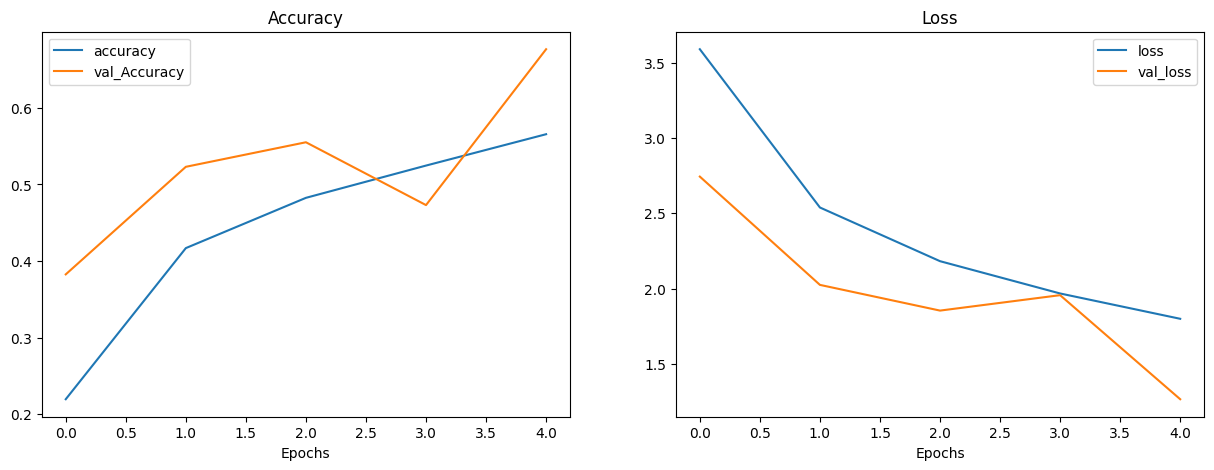

In [32]:
plot_loss_curves(history_all_classes_10_percent)

In [24]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5203 - loss: 1.8783


[1.822424292564392, 0.5301781892776489]

## Fine Tuning

In [25]:
base_model.trainable=True

for layer in base_model.layers[:-5]:
    layer.trainable=False

model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])
for layer in model.layers:
    print(layer.name , layer.trainable)

input_layer True
sequential True
efficientnetb0 True
global_average_pooling2d True
output_layer True


In [26]:
fine_tune_epochs =10

history_all_classes_10_percent_fine_tune =model.fit(
    train_data_all_10_percent ,
    epochs=fine_tune_epochs,
    initial_epoch=history_all_classes_10_percent.epoch[-1],
    validation_data =test_data,
    validation_steps=int(0.15*len(test_data))
    
)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.5571 - loss: 1.8307 - val_accuracy: 0.4899 - val_loss: 1.9840
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.6115 - loss: 1.5847 - val_accuracy: 0.5331 - val_loss: 1.7568
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.6309 - loss: 1.5094 - val_accuracy: 0.5861 - val_loss: 1.6137
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 149ms/step - accuracy: 0.6440 - loss: 1.4396 - val_accuracy: 0.5829 - val_loss: 1.6033
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.6604 - loss: 1.3683 - val_accuracy: 0.6194 - val_loss: 1.4642
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.6727 - loss: 1.3006 - val_accuracy: 0.6014 - val_loss: 1.4686


In [27]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.5487 - loss: 1.7216


[1.6141400337219238, 0.5738613605499268]

In [33]:
def compare_historys(original_history, new_history, initial_epochs=5):
    
    
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

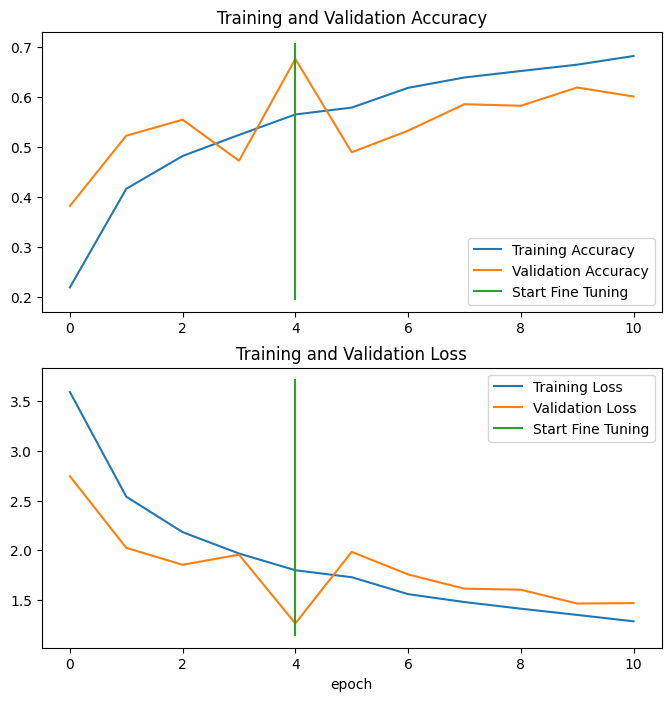

In [34]:
compare_historys(history_all_classes_10_percent,history_all_classes_10_percent_fine_tune)

## Saving and loading our model

In [35]:
model.save("101_food_classes_10_percent.keras")

In [37]:
from tensorflow.keras.models import load_model
loaded_model = load_model("101_food_classes_10_percent.keras")

In [38]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 75ms/step - accuracy: 0.5212 - loss: 1.8474


[1.6901228427886963, 0.5559999942779541]

## Evaluating the performance of the model across all different classes

Loading model

In [51]:
loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5212 - loss: 1.8474


[1.6901228427886963, 0.5559999942779541]

## Making predictions with our trained model

In [52]:
preds_probs =model.predict(test_data , verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step


In [57]:
len(test_data)

790

In [58]:
len(preds_probs)

25250

In [59]:
preds_probs.shape

(25250, 101)

In [61]:
preds_probs[:2]

array([[4.20355886e-01, 7.54884444e-04, 1.73847169e-01, 7.24651329e-07,
        8.87133865e-06, 1.21055327e-05, 5.44017472e-04, 1.09687804e-04,
        2.22420320e-02, 1.08679000e-03, 1.25600618e-05, 2.55990890e-04,
        3.36283911e-03, 9.78282151e-06, 4.71364800e-03, 6.29387854e-04,
        2.29531579e-04, 1.18275231e-03, 3.07366659e-04, 2.30898604e-05,
        4.25660430e-04, 1.06613188e-04, 3.50429036e-04, 2.75880069e-04,
        6.26841385e-04, 3.65142571e-03, 1.25579303e-03, 2.32508792e-05,
        4.19334695e-02, 1.62669073e-03, 2.57955726e-05, 2.43986514e-03,
        5.09560900e-03, 6.77126300e-05, 8.36174563e-03, 1.53971079e-04,
        1.96309388e-03, 1.84510590e-03, 9.62387212e-03, 5.21437287e-05,
        4.70455969e-04, 5.76630817e-04, 2.63133273e-03, 5.32070735e-05,
        5.04304844e-05, 3.88752465e-04, 1.92012405e-03, 1.52468085e-04,
        3.14877325e-05, 5.52793825e-03, 1.27779460e-03, 5.59643668e-05,
        1.46977529e-01, 4.96628881e-03, 1.06996322e-05, 1.213688

In [64]:
len(preds_probs[0])

101

In [65]:
sum(preds_probs[0])

0.9999999739821419

In [69]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"The class with the hihghest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
The class with the hihghest predicted probability by the model for sample 0: 0


Getting preds probs for all test data

In [71]:
pred_classes = preds_probs.argmax(axis=1)

In [72]:
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29, 46,  9,  0])

In [73]:
len(pred_classes)

25250


Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [75]:
y_labels =[]
for images , labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) #currently test labes is like 0 0 0 0 0 1 0 0 0 0 0 0
y_labels[:10] #looking for first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since we have done shuffle=False in test data hence all test data of label 0 coming first

In [77]:
len(y_labels) ,len(pred_classes)

(25250, 25250)

In [78]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## Evaluating our model's predictions

In [79]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels , pred_classes)
sklearn_accuracy

0.5738613861386138

#### Making confusion matrix

In [82]:
class_names = test_data.class_names
class_names[:22]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake']

In [83]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)


In [84]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.28      0.18      0.22       250
           1       0.43      0.74      0.54       250
           2       0.57      0.55      0.56       250
           3       0.79      0.50      0.61       250
           4       0.51      0.43      0.47       250
           5       0.40      0.31      0.35       250
           6       0.78      0.69      0.73       250
           7       0.78      0.74      0.76       250
           8       0.26      0.50      0.34       250
           9       0.40      0.58      0.48       250
          10       0.48      0.43      0.45       250
          11       0.65      0.61      0.63       250
          12       0.76      0.53      0.62       250
          13       0.50      0.54      0.52       250
          14       0.49      0.51      0.50       250
          15       0.41      0.28      0.33       250
          16       0.67      0.47      0.55       250
          17       0.39    

In [86]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.27848101265822783,
  'recall': 0.176,
  'f1-score': 0.2156862745098039,
  'support': 250},
 '1': {'precision': 0.431924882629108,
  'recall': 0.736,
  'f1-score': 0.5443786982248521,
  'support': 250},
 '2': {'precision': 0.575,
  'recall': 0.552,
  'f1-score': 0.563265306122449,
  'support': 250},
 '3': {'precision': 0.7911392405063291,
  'recall': 0.5,
  'f1-score': 0.6127450980392157,
  'support': 250},
 '4': {'precision': 0.5142857142857142,
  'recall': 0.432,
  'f1-score': 0.46956521739130436,
  'support': 250},
 '5': {'precision': 0.40414507772020725,
  'recall': 0.312,
  'f1-score': 0.35214446952595935,
  'support': 250},
 '6': {'precision': 0.7757847533632287,
  'recall': 0.692,
  'f1-score': 0.7315010570824525,
  'support': 250},
 '7': {'precision': 0.7815126050420168,
  'recall': 0.744,
  'f1-score': 0.7622950819672131,
  'support': 250},
 '8': {'precision': 0.2587991718426501,
  'recall': 0.5,
  'f1-score': 0.34106412005457026,
  'support': 250},
 '9': 

In [88]:
class_names[98]

'tiramisu'

In [89]:
classification_report_dict["99"]

{'precision': 0.37349397590361444,
 'recall': 0.248,
 'f1-score': 0.2980769230769231,
 'support': 250}

## F1 SCORE GRAPH

## F1 SCORE GRAPH

In [90]:
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2156862745098039,
 'baby_back_ribs': 0.5443786982248521,
 'baklava': 0.563265306122449,
 'beef_carpaccio': 0.6127450980392157,
 'beef_tartare': 0.46956521739130436,
 'beet_salad': 0.35214446952595935,
 'beignets': 0.7315010570824525,
 'bibimbap': 0.7622950819672131,
 'bread_pudding': 0.34106412005457026,
 'breakfast_burrito': 0.4761904761904762,
 'bruschetta': 0.452431289640592,
 'caesar_salad': 0.6283367556468172,
 'cannoli': 0.6241134751773051,
 'caprese_salad': 0.521072796934866,
 'carrot_cake': 0.5029469548133596,
 'ceviche': 0.33093525179856115,
 'cheese_plate': 0.5526932084309134,
 'cheesecake': 0.4091778202676864,
 'chicken_curry': 0.4419475655430712,
 'chicken_quesadilla': 0.5964912280701754,
 'chicken_wings': 0.6726296958855098,
 'chocolate_cake': 0.5285996055226826,
 'chocolate_mousse': 0.30303030303030304,
 'churros': 0.7460674157303371,
 'clam_chowder': 0.7016129032258064,
 'club_sandwich': 0.6562500000000001,
 'crab_cakes': 0.37988826815642457,
 'creme_brul

In [91]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
     

# What does our dataframe look like?
f1_scores[:10]

class_names  f1-score
33              edamame  0.953125
75                  pho  0.815109
63             macarons  0.812065
86              sashimi  0.808271
64            miso_soup  0.806202
32            dumplings  0.804598
54    hot_and_sour_soup  0.803960
51            guacamole  0.794007
65              mussels  0.791753
91  spaghetti_carbonara  0.786885

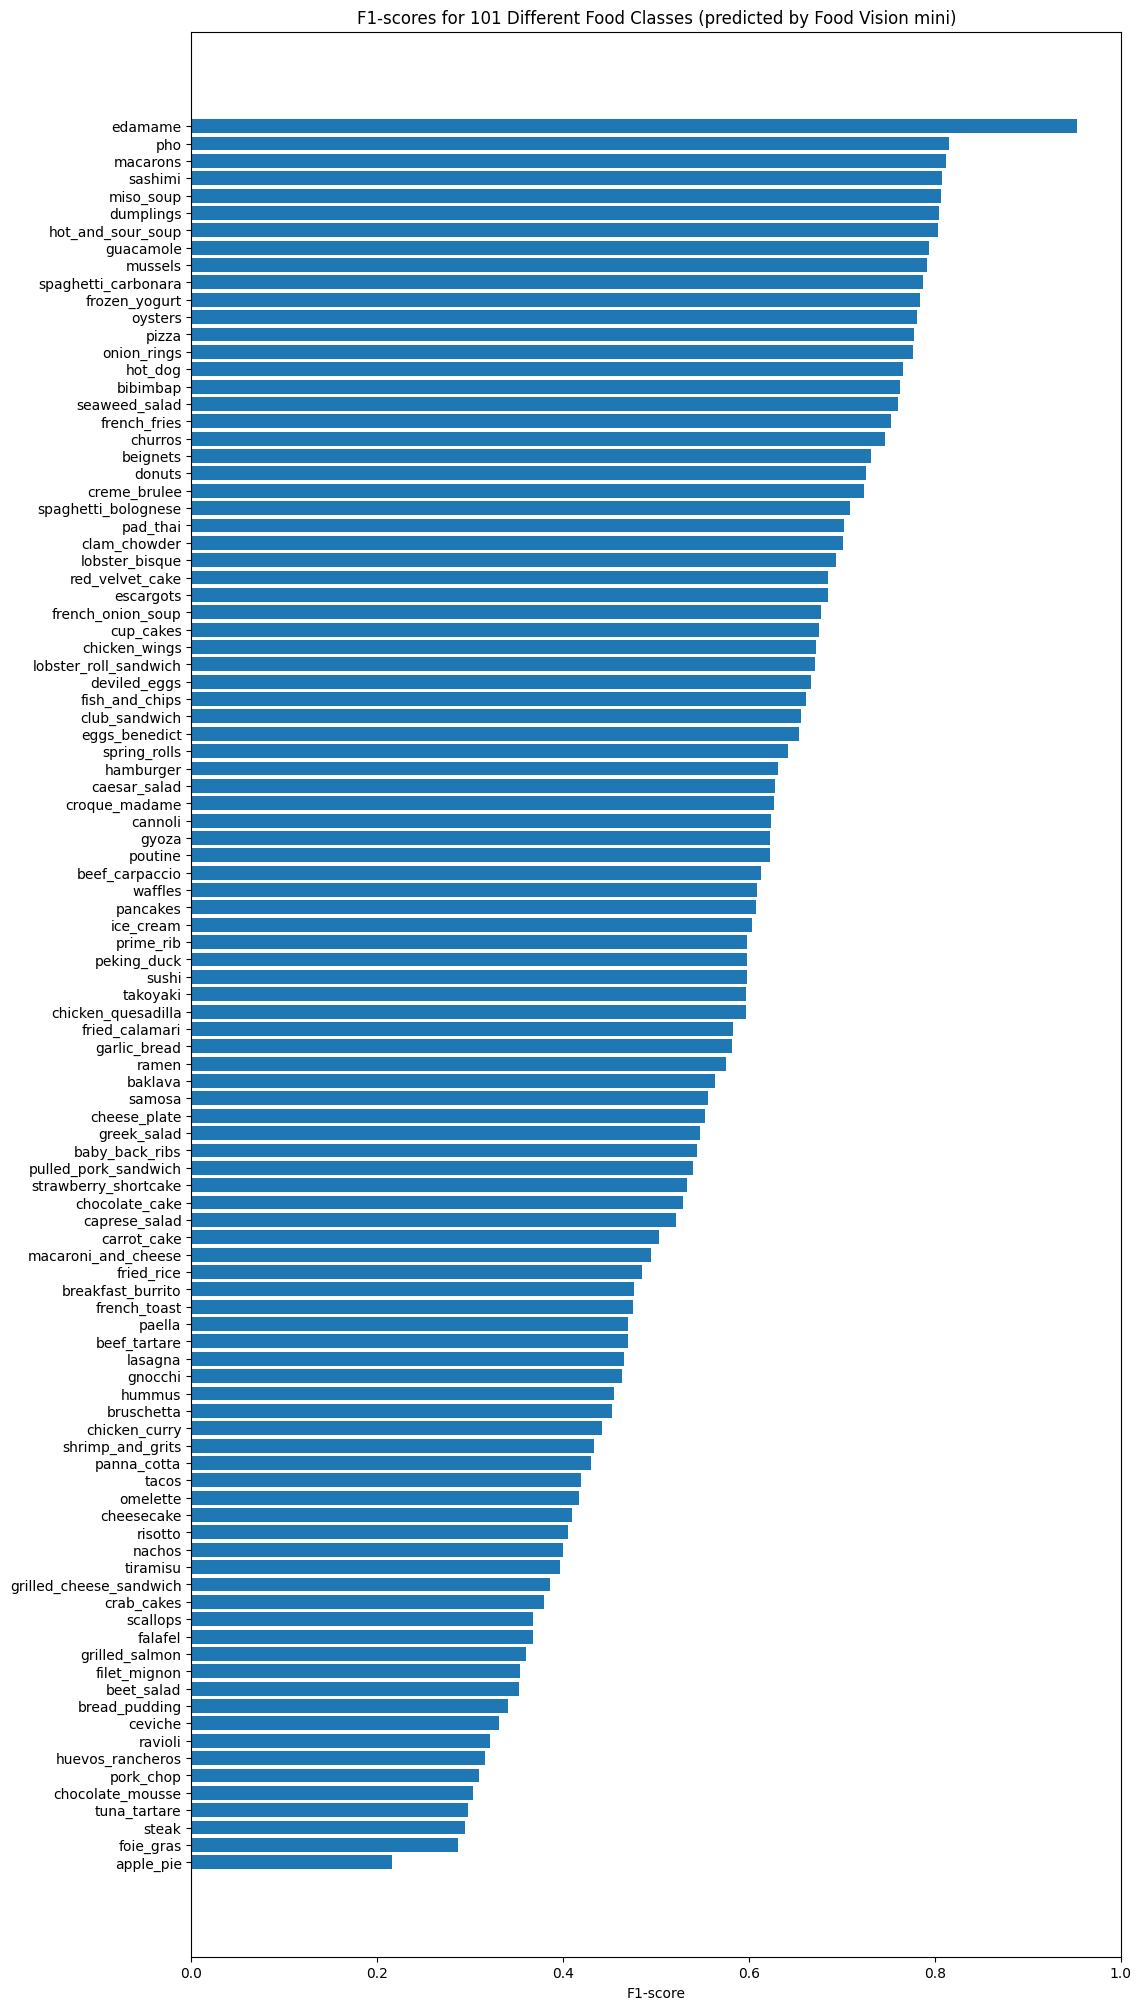

In [92]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot
